Import Library


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


from sklearn.preprocessing  import StandardScaler
from imblearn.over_sampling import RandomOverSampler

Import Dataset

In [32]:
# Load dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00225/Indian%20Liver%20Patient%20Dataset%20(ILPD).csv"
df = pd.read_csv(data_url, header=None)


Name The coloumns

In [33]:
df.columns = ["Age", "Gender", "TB", "DB", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/G Ratio", "Liver Disease"]

Encode categorical variable

In [34]:
df["Gender"] = LabelEncoder().fit_transform(df["Gender"])
print(df)

     Age  Gender    TB   DB  Alkphos  Sgpt  Sgot   TP  ALB  A/G Ratio  \
0     65       0   0.7  0.1      187    16    18  6.8  3.3       0.90   
1     62       1  10.9  5.5      699    64   100  7.5  3.2       0.74   
2     62       1   7.3  4.1      490    60    68  7.0  3.3       0.89   
3     58       1   1.0  0.4      182    14    20  6.8  3.4       1.00   
4     72       1   3.9  2.0      195    27    59  7.3  2.4       0.40   
..   ...     ...   ...  ...      ...   ...   ...  ...  ...        ...   
578   60       1   0.5  0.1      500    20    34  5.9  1.6       0.37   
579   40       1   0.6  0.1       98    35    31  6.0  3.2       1.10   
580   52       1   0.8  0.2      245    48    49  6.4  3.2       1.00   
581   31       1   1.3  0.5      184    29    32  6.8  3.4       1.00   
582   38       1   1.0  0.3      216    21    24  7.3  4.4       1.50   

     Liver Disease  
0                1  
1                1  
2                1  
3                1  
4                1

In [35]:

# for label in df.columns[:-1]:
#   plt.hist(df[df["Gender"] == 1][label], color ='blue' , label = 'Male', alpha= 0.7 ,density = True )
#   plt.hist(df[df["Gender"] == 0][label], color ='red' , label = 'Female', alpha= 0.7 ,density = True )
#   plt.title(label)
#   plt.ylabel("Probability")
#   plt.xlabel(label)
#   plt.legend()
#   plt.show()


 Fill missing values

In [36]:

for col in df.columns:
    if col == "Gender":
        # most frequent (mode)
        df[col].fillna(df[col].mode()[0], inplace=True)
    elif col == "Liver Disease":
        # median
        df[col].fillna(df[col].median(), inplace=True)
    else:
        # mean for all other numeric features
        df[col].fillna(df[col].mean(), inplace=True)


/tmp/ipython-input-3843203570.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipython-input-3843203570.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

Separate Target Column

In [37]:
X = df.drop(columns=["Liver Disease","TP"])
# "TP" has negative impact
y = df["Liver Disease"]
feature_names = X.columns.tolist()

In [38]:
feature_names

['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'ALB', 'A/G Ratio']

Balance Dataset by Smote

In [39]:
# Before SMOTE
print("Before SMOTE:")
print(df["Liver Disease"].value_counts())
# Balance dataset using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
print("\nAfter SMOTE:")
print(pd.Series(y).value_counts())

Before SMOTE:
Liver Disease
1    416
2    167
Name: count, dtype: int64

After SMOTE:
Liver Disease
1    416
2    416
Name: count, dtype: int64


Convert the class of target column from {1,2} to -> {0,1}

In [40]:
# convert labels from {1,2} → {0,1}
y = y - 1

In [41]:
# # Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Scaling

In [42]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

Define ML model model object



In [43]:
# ----- Machine Learning Models -----
# include additional ensemble and tuned models
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier

# define base estimators
base_knn = KNeighborsClassifier()
base_svc = SVC(probability=True)


Define model

In [44]:
ml_models = {
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance'),
    "SVM": SVC(kernel='rbf', C=10, gamma=0.1, probability=True),
    "Logistic Regression": LogisticRegression(solver='liblinear', C=1.0),
    "Ensemble - Bagging": BaggingClassifier(random_state=42),
    # "Ensemble - AdaBoost": AdaBoostClassifier(random_state=42),

}


Train, predict and evaluate Accuracy

In [45]:
# --- Train ML models (re‑define or assume ml_models exists) ---
ml_results = {}
for name, model in ml_models.items():
    print(f"Training ML: {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ml_results[name] = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {ml_results[name]:.4f}\n")



Training ML: Naive Bayes...
Naive Bayes Accuracy: 0.6647

Training ML: KNN...
KNN Accuracy: 0.7246

Training ML: SVM...
SVM Accuracy: 0.7545

Training ML: Logistic Regression...
Logistic Regression Accuracy: 0.7665

Training ML: Ensemble - Bagging...
Ensemble - Bagging Accuracy: 0.8204



In [46]:
# Find the model with the highest accuracy
best_model_name = max(ml_results, key=ml_results.get)
best_accuracy = ml_results[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Highest Accuracy: {best_accuracy:.4f}")

Best Model: Ensemble - Bagging
Highest Accuracy: 0.8204


Plot the result

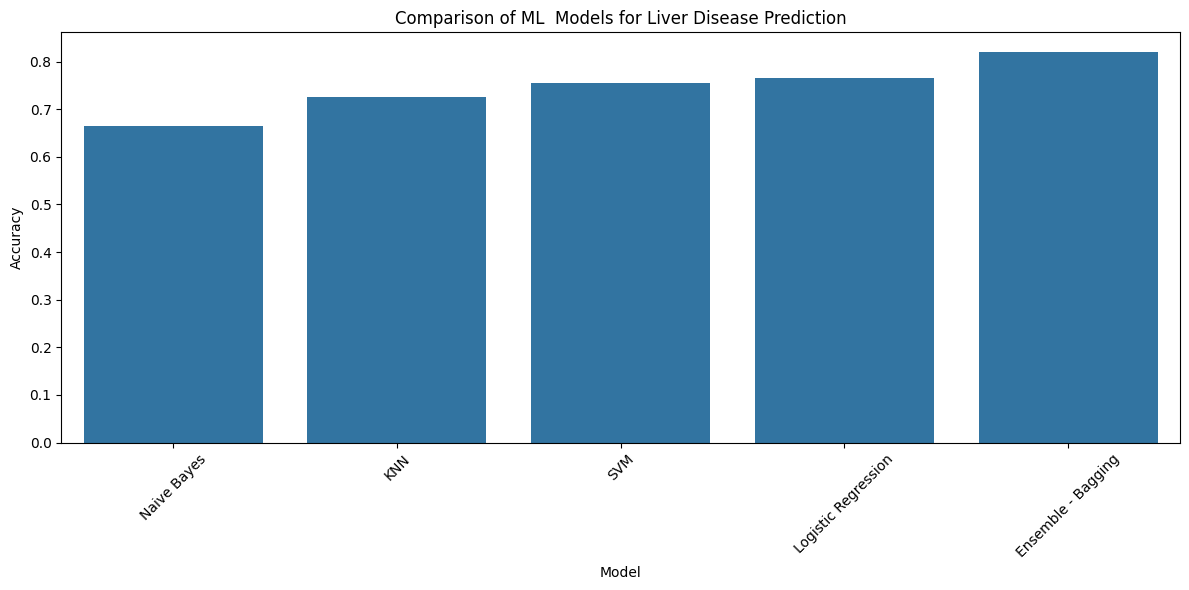

In [47]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
all_results = {**ml_results }       # now both dicts exist
sns.barplot(x=list(all_results.keys()), y=list(all_results.values()))
plt.xticks(rotation=45)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of ML  Models for Liver Disease Prediction")
plt.tight_layout()
plt.show()

In [48]:
X.columns

Index(['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'ALB',
       'A/G Ratio'],
      dtype='object')

In [49]:
# ---- Prediction Function ----
def predict_liver_disease(model, scaler, input_data, feature_names):
    """
    Predict liver disease from input features.

    Parameters:
        model : trained ML model
        scaler : fitted StandardScaler
        input_data : list or array of features [Age, Gender, TB, DB, Alkphos, Sgpt, Sgot, ALB, A/G Ratio]
        feature_names : list of feature names (used for consistency)

    Returns:
        str : prediction result ("Liver Disease" or "No Liver Disease")
    """

    # Convert input into DataFrame for consistency
    input_df = pd.DataFrame([input_data], columns=feature_names)

    # Scale the input
    input_scaled = scaler.transform(input_df)

    # Prediction
    pred = model.predict(input_scaled)[0]

    # Convert to label
    if pred == 1:
        return "Liver Disease"
    else:
        return "No Liver Disease"


In [50]:
# Suppose best_model_name holds your best model key
best_model = ml_models[best_model_name]

# Example patient data (must match X_train columns order):
# Age, Gender, TB, DB, Alkphos, Sgpt, Sgot, ALB, A/G Ratio
sample_patient = [45, 1, 1.2, 0.5, 200, 30, 40, 4.5, 1.2]

result = predict_liver_disease(best_model, scaler, sample_patient, feature_names)
print("Prediction:", result)


Prediction: Liver Disease


In [53]:
sample_patient = [21, 1, 18.5, 9.5, 380, 390, 500, 4.1, 1]
result = predict_liver_disease(best_model, scaler, sample_patient, feature_names)
print("Prediction:", result)

Prediction: No Liver Disease


In [54]:
sample_data = [4, 1, 0.9, 0.2, 348, 30, 34, 4, 1]
result = predict_liver_disease(best_model, scaler, sample_data, feature_names)
print("Prediction:", result)

Prediction: Liver Disease


Save model & scaler as .pkl (or .joblib)

In [51]:
import joblib
import json

# Save best model and scaler
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# Save feature names (very important for prediction order)
with open("feature_names.json", "w") as f:
    json.dump(feature_names, f)

print("Files saved: best_model.pkl, scaler.pkl, feature_names.json")


Files saved: best_model.pkl, scaler.pkl, feature_names.json


In [52]:
# !pip freeze > requirements.txt
# from google.colab import files
# files.download("requirements.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>